In [157]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import trange

import sys
sys.path.append("../")
from models import ResNet18
from helpers import get_model_size, estimate_loss, normalize_tensor, CiFaData, get_parameters

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
EPOCHS = 110
BATCH_SIZE = 1024
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

In [197]:
# we actually just need it to download cifar dataset
# torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
# torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

tf = transforms.Compose([transforms.RandomCrop(32, padding=4), 
                         transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomErasing(),
                         transforms.RandomRotation(10)])
                        #  transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
                        #  transforms.RandomAffine(degrees=90)]) 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# create loader to get the params
# complete_ds = CiFaData(stage="all", path='../data/')
# big_loader = DataLoader(complete_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14)
# params = get_parameters(big_loader)

# params = torch.tensor([0.4919, 0.4827, 0.4472]), torch.tensor([0.2470, 0.2434, 0.2616])
print(f"normalized parameters of the dataset: {params}")

train_ds = CiFaData(stage="train", path='../data/', transform=tf, dataset_params=params)
val_ds = CiFaData(stage="val", path='../data/', dataset_params=params)
test_ds = CiFaData(stage="test", path='../data/', dataset_params=params)

# pinning memory, takes cpu data and pins it to the gpu.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=14, pin_memory=True) 
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)

loading the dataset
calculate the parameters
normalized parameters of the dataset: (tensor([125.4265, 123.0767, 114.0302]), tensor([62.9777, 62.0642, 66.7061]))


ResNet 18

model size: 18.756 MB


epoch 110 | training loss: 0.3842 | validation loss: 0.529243 | current lr: 6.390146580867756e-07 | validation accuracy: 0.84: 100%|██████████| 110/110 [05:13<00:00,  2.85s/it] 


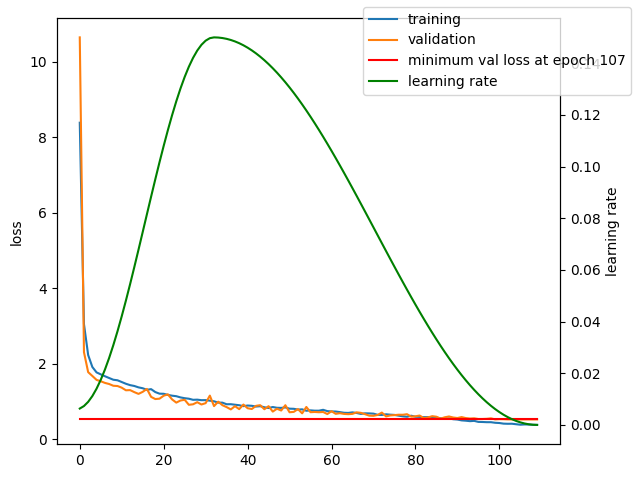

In [200]:
model = ResNet18()
model.init_weights()
model.to(device)

# optimizer = optim.AdamW(params=[p for p in model.parameters() if p.requires_grad==True], lr=LR)
optimizer = optim.SGD(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
# the initial lr is calculated instead of taken from optim: max_lr / div_factor
scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer, steps_per_epoch=int(train_loader.__len__()),
                                    epochs=EPOCHS, max_lr=0.15, anneal_strategy='cos') # , three_phase=True, final_div_factor=1000)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=.1, patience=5)
# schedule = {
#   15: 1e-2,
#   60: 1e-3,
#   65: 1e-4,
#   60: 1e-5
# }
criterion = nn.CrossEntropyLoss()
model_size = get_model_size(model)

# training loop
losses = []
val_losses = []
all_the_lrs = []
lrs = []

for epoch in (t:=trange(EPOCHS)):
  model.train()
  running_loss = []
  for step, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
    predictions = model(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    all_the_lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step() # with the onecycle scheduler, we step after every batch
    running_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(running_loss))
  val_loss, val_acc = estimate_loss(model, val_loader, criterion, device)
  val_losses.append(val_loss)
  # scheduler.step(metrics=val_loss)
  # if epoch in schedule.keys():
  #   optimizer.param_groups[0]['lr'] = schedule[epoch]
  lrs.append(optimizer.param_groups[0]['lr'])
  t.set_description(f"epoch {epoch+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.6f} | current lr: {lrs[-1]} | validation accuracy: {val_acc:.2f}")

fig, ax1 = plt.subplots()
ax1.plot(range(len(losses)), losses, label='training')
ax1.plot(range(len(val_losses)), val_losses, label='validation')
ax1.plot(range(len(val_losses)), [np.min(val_losses)]*EPOCHS, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
ax1.set_ylabel('loss')
ax2 = ax1.twinx()
ax2.set_ylabel('learning rate')
ax2.plot(range(len(lrs)), lrs, color='green', label='learning rate')
fig.tight_layout()
fig.legend()
plt.show()

In [24]:
# inspect the graph
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, x)
writer.close()

In [25]:
with open('../data/cifar-10-batches-py/batches.meta', 'rb') as f:
  meta = pickle.load(f)
meta['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
n = 9
input_ = x[n].cpu().permute(1,2,0).numpy()

plt.title(meta['label_names'][y[n]])
plt.imshow(input_)

# vizualize filters



In [201]:
model

ResNet18(
  (resnet): Sequential(
    (0): PrepBlock(
      (prep_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (1): ComputeBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (2): ComputeBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

In [202]:
def visualize_filters(weights):
  if not weights.shape[1] == 3:
    weights = weights[:, 0:1, :, :]
    
  filter_img = torchvision.utils.make_grid(weights, nrow=int(np.sqrt(weights.shape[0])), normalize=True)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(filter_img.permute(1,2,0))
  plt.show()

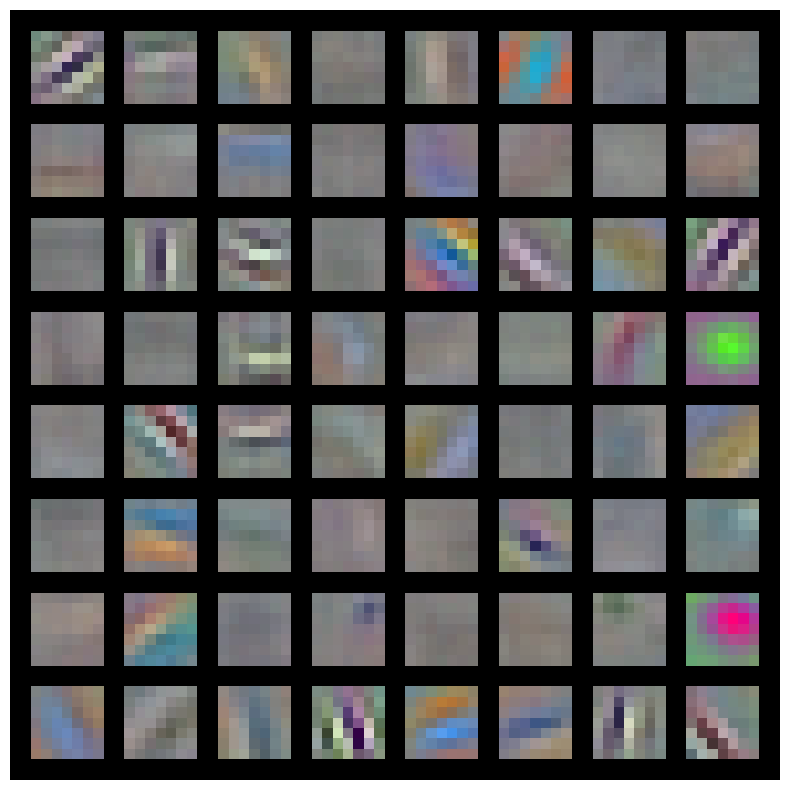

In [203]:
visualize_filters(model.resnet[0].prep_block[0].weight.detach().cpu().clone())

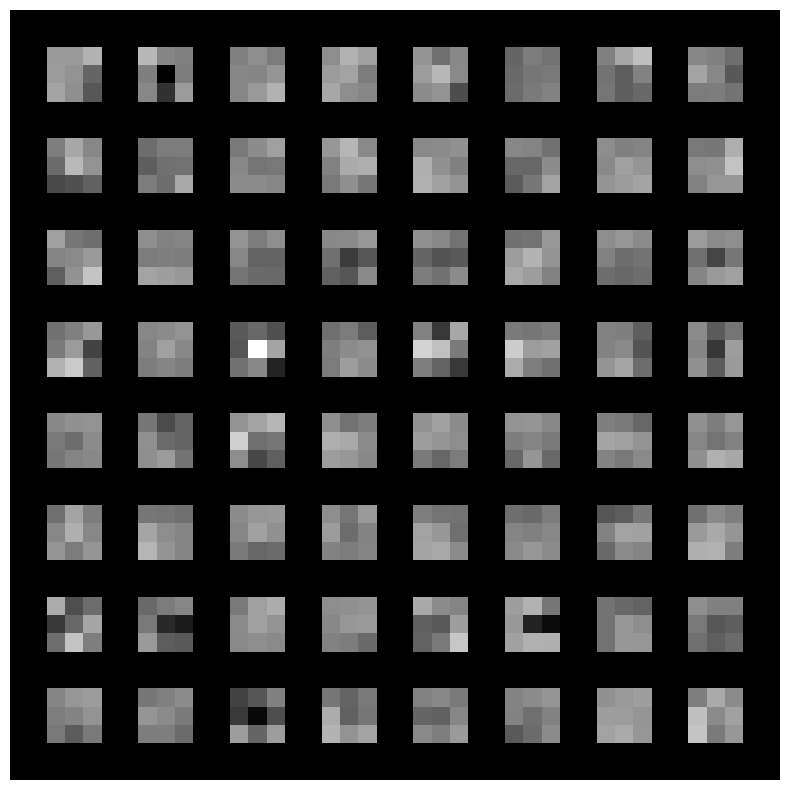

In [204]:
visualize_filters(model.resnet[1].convblock[0].weight.detach().cpu().clone())

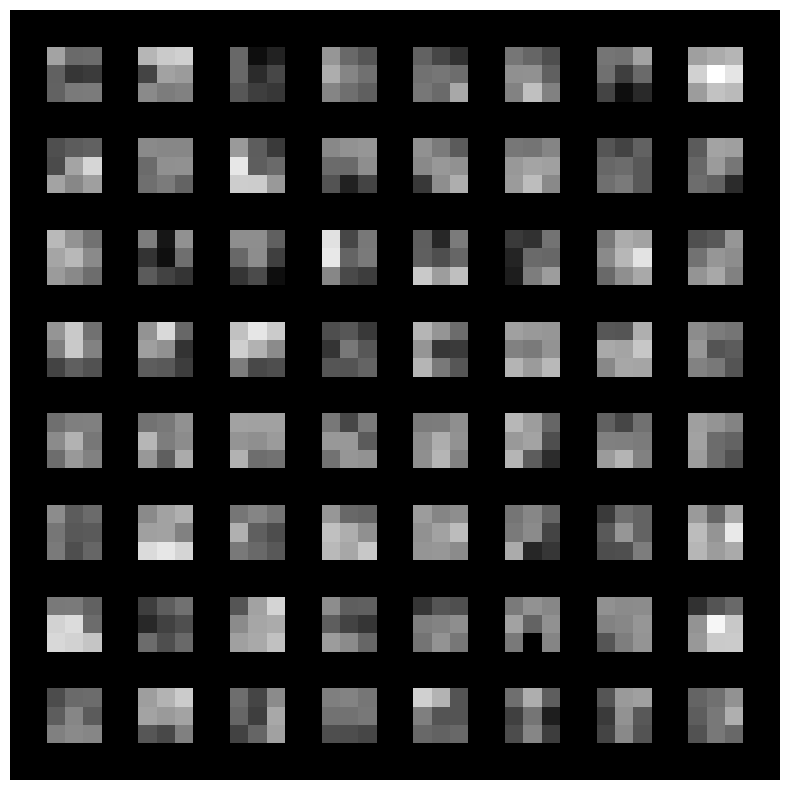

In [205]:
visualize_filters(model.resnet[1].convblock[3].weight.detach().cpu().clone())

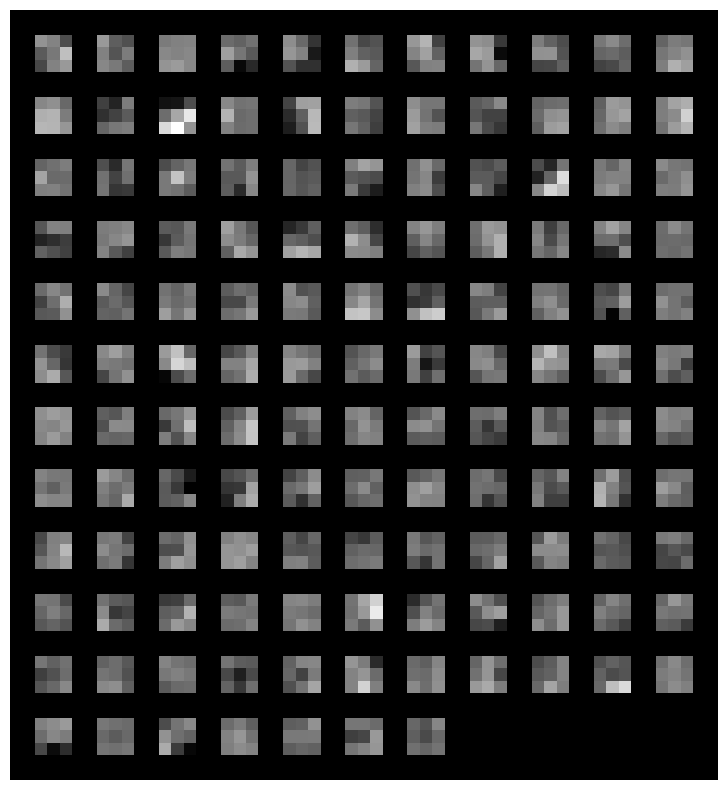

In [206]:
visualize_filters(model.resnet[2].convblock[0].weight.detach().cpu().clone())

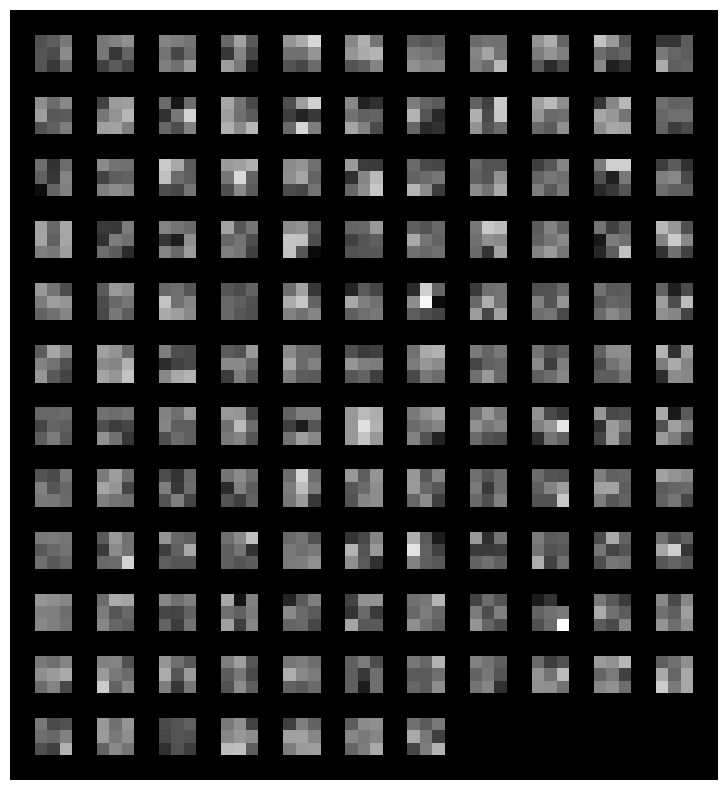

In [207]:
visualize_filters(model.resnet[2].convblock[3].weight.detach().cpu().clone())

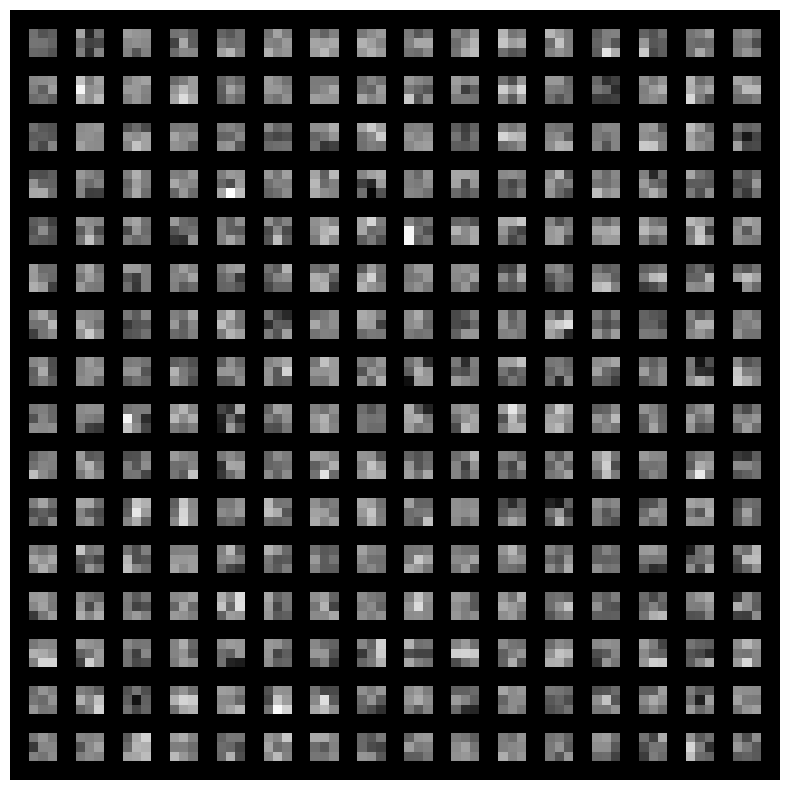

In [208]:
visualize_filters(model.resnet[3].convblock[0].weight.detach().cpu().clone())

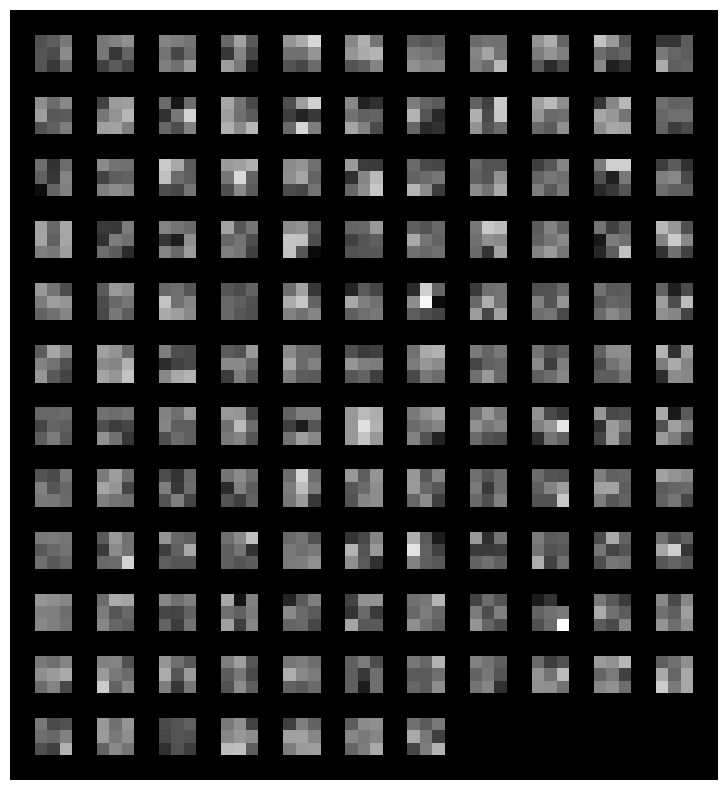

In [209]:
visualize_filters(model.resnet[2].convblock[3].weight.detach().cpu().clone())

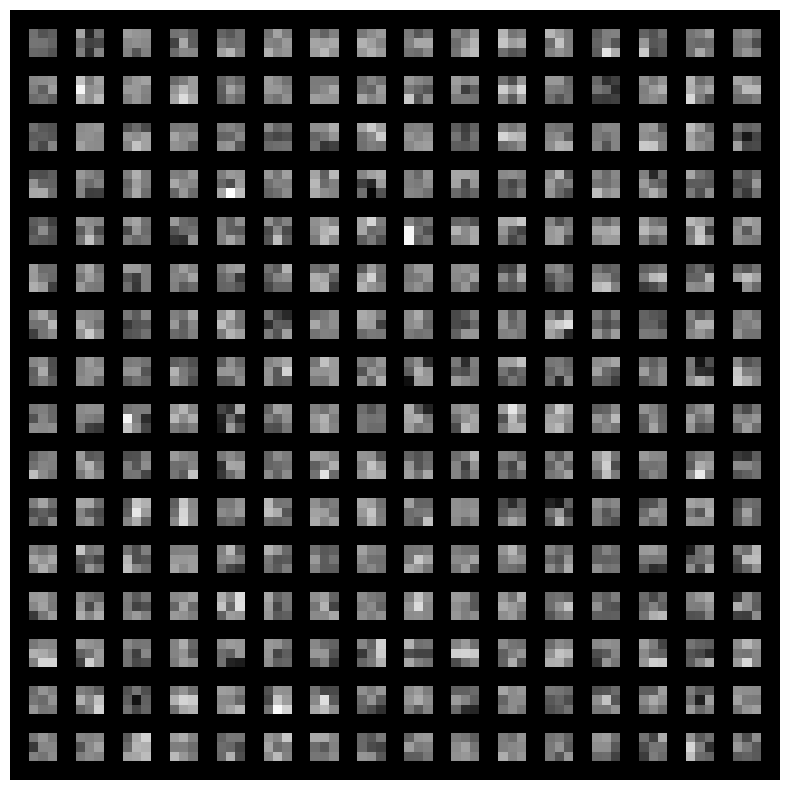

In [210]:
visualize_filters(model.resnet[3].convblock[0].weight.detach().cpu().clone())

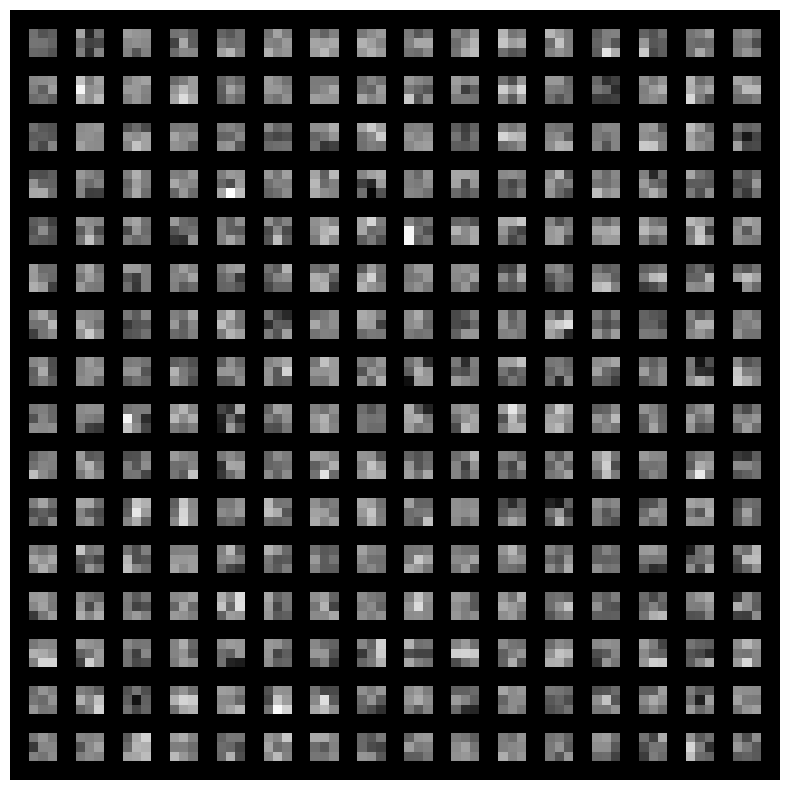

In [211]:
visualize_filters(model.resnet[3].convblock[0].weight.detach().cpu().clone())

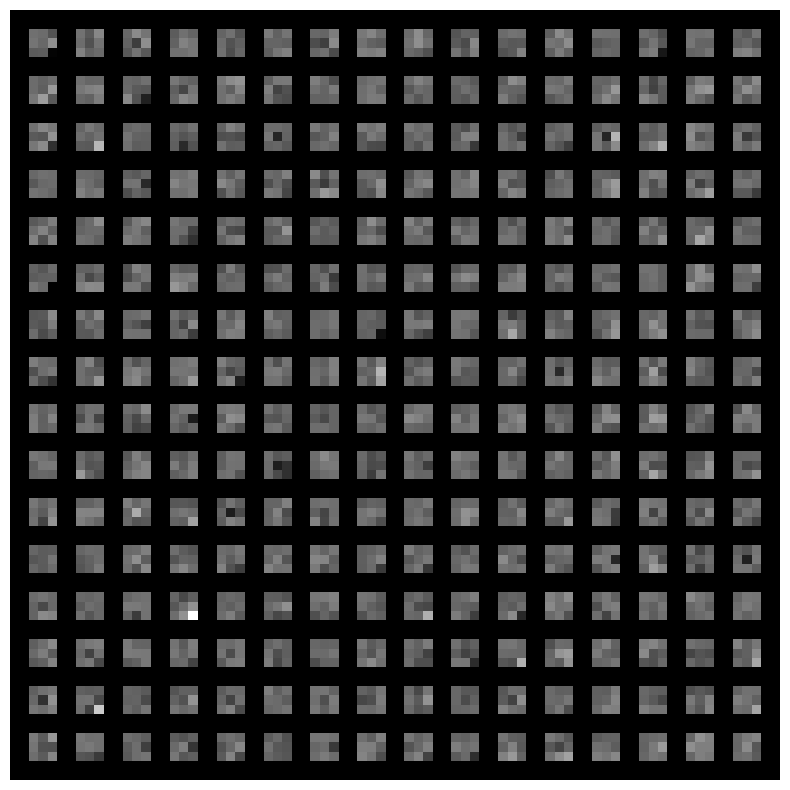

In [212]:
visualize_filters(model.resnet[3].convblock[3].weight.detach().cpu().clone())

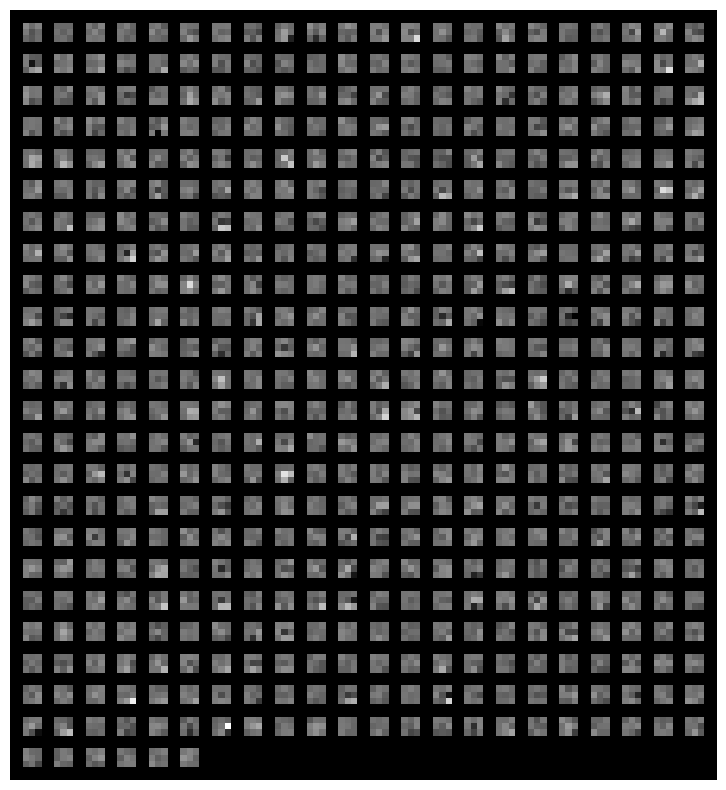

In [213]:
visualize_filters(model.resnet[4].convblock[0].weight.detach().cpu().clone())

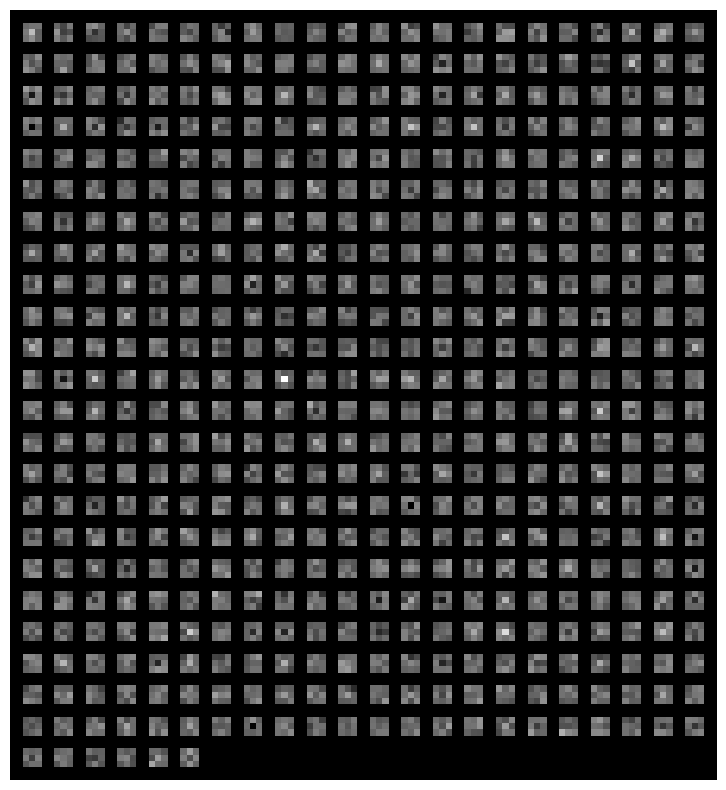

In [214]:
visualize_filters(model.resnet[4].convblock[3].weight.detach().cpu().clone())

In [217]:
model


ResNet18(
  (resnet): Sequential(
    (0): PrepBlock(
      (prep_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (1): ComputeBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (2): ComputeBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

In [218]:
model_children

[Sequential(
   (0): PrepBlock(
     (prep_block): Sequential(
       (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     )
   )
   (1): ComputeBlock(
     (convblock): Sequential(
       (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (relu): ReLU()
   )
   (2): ComputeBlock(
     (convblock): Sequential(
       (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128,

In [223]:
len(model_children)

1

In [225]:
for block in model_children[0]:
  for 

<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>


In [215]:
# feature maps: 
# extract all conv layers
weights = []
conv_layers = []
cnt = 0
model_children = list(model.children()) 
for layer in model_children:
  if type(layer) == nn.Conv2d:
    cnt += 1
    weights.append(layer.weight)
    conv_layers.append(layer)
  elif type(layer) == nn.Sequential:
   for i in range(len(layer)):
     for child in layer[i].children():
       if type(child) == nn.Conv2d:
         cnt += 1
         weights.append(child.weight)
         conv_layers.append(child)

print(f'total conv layers: {cnt}')
print(conv_layers)

total conv layers: 0
[]


In [216]:
# take an image, make inference of layer and create feature map
image = [x for x,_ in test_loader][0]
out = []
names = []
for layer in conv_layers:
  out.append(layer(image))
  names.append(str(layer))

processed = []
for feature_map in out:
  feature_map = feature_map.squeeze(0)
  

# todos:
## increase size: make a resnet 50
### add bottlenecks